![ibm-cloud.png](attachment:ibm-cloud.png)

## Setup your notebook file stystem on Watson Studio

All of the notebooks in these courses are written to run locally on your computer running a Jupyter notebook server.  If you wish to run the notebooks in Watson Studio in the IBM Cloud, you will need to add some modifications to each notebook.

Why?  Because once you import a course notebook and the data files for that notebook into a Watson Studio project, the data files are no longer available to the notebook! 
This is simply due to the fact that the imported data files are stored in an IBM Cloud Object Storage (COS) bucket.  The notebook does not have access to those objects in the COS bucket.  Thus, if you import a notebook and its data files into a Studio project then try to run it, the notebook will return "File not found" errors. 
In order to make the data files available to your notebook, you will need to run some code in your notebook to: 

1 - Access the correct COS bucket <br>
2 - Read your data file from the bucket into a byte stream object <br>
3 - Write that byte stream object to the virtual disk of the container running the notebook. 

First, in order to access the correct COS bucket, you need to <b>insert a project token</b>. To do so, click the <b>More</b> icon on your notebook toolbar and then click <b>Insert project token</b>.

![Insert%20Porject%20Token%20pict.png](attachment:Insert%20Porject%20Token%20pict.png)

A new cell will be added on top of your notebook. Running this cell allows to create the <b>"project"</b> object that will allow us to access the COS bucket. After running this new cell, run the following two coding cells to write the data files in the virtual disk of the container running this notebook. You are ready to start the study case !

In [ ]:
# cos2file - takes an object from Cloud Object Storage and writes it to file on container file system.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: project object defined in project token
# data_path: the directory to write the file
# filename: name of the file in COS

import os
def cos2file(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    open( data_dir + '/' + filename, 'wb').write(p.get_file(filename).read())

In [ ]:
# Calling cos2file allows to make the data files available to the notebook 
cos2file(project, '/data', 'world-happiness.csv')
cos2file(project, '/scripts', 'make-happiness-summary-plot.py')
os.mkdir(os.path.join(project.project_context.home, "images"))

# Data Visualization

The first steps of the EDA process are to summarize the data and use storytelling to connect the business opportunity to the data.  [Jupyter notebooks](http://jupyter.org) are arguably the principal tool of the data science community for EDA.  There are other similarly powerful tools like [Zeppelin](https://zeppelin.apache.org) and [RStudio](https://www.rstudio.com), but Jupyter has become an industry standard in the Python ecosystem.  Ironically, there is even a project called [nbestimate](https://github.com/parente/nbestimate) that collects statistics about the number of Jupyter notebooks in [GitHub](https://github.com) then [performs some data visualization on the results](https://nbviewer.jupyter.org/github/parente/nbestimate/blob/master/estimate.ipynb).  Currently, there are more than 5 million notebooks saved in GitHub..  

Despite widespread adoption there is one important caveat to keep in mind---they do not work well with [version control](https://en.wikipedia.org/wiki/Version_control).

### Getting started

**This unit is interactive**.  During this unit we encourage you to [open this file as a notebook](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest).  Download the notebook from the following link then open it locally using a Jupyter server or use your IBM cloud account to login to Watson Studio.  Inside of Watson Studio cloud if you have not already ensure that this notebook is loaded as part of the *project* for this course. As a reminder fill in all of the places in this notebook marked with ***YOUR CODE HERE*** or ***YOUR ANSWER HERE***.

**You will need the following files to complete this case study**

* [m2-u2-data-visualization.ipynb](m2-u2-data-visualization.ipynb)
* [world-happiness.csv](../data/world-happiness.csv)
* [make-happiness-summary-plot.py](../scripts/make-happiness-summary-plot.py)

This unit is organized into the following sections:

1. EDA and pandas
2. Data visualization best practices
2. Essentials of matplotlib
3. Pairs plots and correlation
4. Beyond simple plots

### Data visualization in Python


This unit covers the topic of data visualization and this course is taught in Python.  There are numerous frameworks out there and it is reasonable to use other languages, like R, to carry out data visualization.  The reason for using matplotlib is that it is most common tool once you have accounted for direct and indirect usage.  See the visualization below to get a better understanding how matplotlib fits into the Python landscape of visualization tools.

![PythonVisLandscape.jpg](attachment:PythonVisLandscape.jpg)

The image was created by [Jake Vanderplas](http://vanderplas.com) at the [eScience institute](https://escience.washington.edu) and if you are interested in learning more then [Anaconda has an article on the topic](https://www.anaconda.com/python-data-visualization-2018-why-so-many-libraries).

We will focus on simple plots and for this the `matplotlib` and `seaborn` libraries are the most widely used.

It is expected that you already know and use both pandas and matplotlib on a regular basis.  For those of you who are comfortable with plotting---meaning that you can readily produce any of the several dozen types common plots used in data science, then this unit will serve as a review.  In the above sections we will touch on the essential tools, best practices and survey the landscape of available tools for more advanced plotting.

If you would like additional context a few links are available below:

- [Anaconda's article on 'moving toward convergence'](https://www.anaconda.com/blog/developer-blog/python-data-visualization-moving-toward-convergence/)
- [Anaconda's article on the future of Python visualization libraries](https://www.anaconda.com/blog/developer-blog/python-data-visualization-2018-where-do-we-go-from-here/)

- [Matplotlib tutorial](http://www.scipy-lectures.org/intro/matplotlib/matplotlib.html)

First let's make all of the necessary imports and configure the plot fonts.  If you use Jupyter notebooks as a presentation tool then ensuring that your fonts are readable both the professional things to do and it will help with communication.

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

## specify the directory you saved the data and images in
DATA_DIR = os.path.join("","data")
IMAGE_DIR = os.path.join("","images")

Let's load the data that we will be using to practice EDA and then perform some basic cleanup.

In [ ]:
## load the data and print the shape
df = pd.read_csv(os.path.join(DATA_DIR, "world-happiness.csv"), index_col=0)
print("df: {} x {}".format(df.shape[0], df.shape[1]))

## clean up the column names
df.columns = [re.sub("\s+","_",col) for col in df.columns.tolist()]

## check the first few rows
df.head(n=4)

df: 495 x 12


,Country,Region,Happiness_Rank,Happiness_Score,Economy_(GDP_per_Capita),Family,Health_(Life_Expectancy),Freedom,Trust_(Government_Corruption),Generosity,Dystopia_Residual,Year
0,Afghanistan,Southern Asia,153.0,3.575,0.31982,0.30285,0.30335,0.23414,0.09719,0.36510,1.95210,2015
1,Albania,Central and Eastern Europe,95.0,4.959,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894,2015
2,Algeria,Middle East and Northern Africa,68.0,5.605,0.93929,1.07772,0.61766,0.28579,0.17383,0.07822,2.43209,2015
3,Angola,Sub-Saharan Africa,137.0,4.033,0.75778,0.86040,0.16683,0.10384,0.07122,0.12344,1.94939,2015


In [ ]:
## missing values summary
print("Missing Value Summary\n{}".format("-"*35))
print(df.isnull().sum(axis = 0))

Missing Value Summary
-----------------------------------
Country                           0
Region                            0
Happiness_Rank                   25
Happiness_Score                  25
Economy_(GDP_per_Capita)         25
Family                           25
Health_(Life_Expectancy)         25
Freedom                          25
Trust_(Government_Corruption)    25
Generosity                       25
Dystopia_Residual                25
Year                              0
dtype: int64


In [ ]:
## drop the rows that have NaNs
print("Original Matrix:", df.shape)
df.dropna(inplace=True)
print("After NaNs removed:", df.shape)

Original Matrix: (495, 12)
After NaNs removed: (470, 12)


### The data

The original data are produced by the [UN Sustainable Development Solutions Network (SDSN)](https://www.unsdsn.org) and the report is compiled and available at [https://worldhappiness.report](https://worldhappiness.report). The following  is the messaging on the report website:

> The World Happiness Report is a landmark survey of the state of global happiness that ranks 156 countries by how happy their citizens perceive themselves to be. The report is produced by the United Nations Sustainable Development Solutions Network in partnership with the Ernesto Illy Foundation.
 
> The World Happiness Report was written by a group of independent experts acting in their personal capacities. Any views expressed in this report do not necessarily reflect the views of any organization, agency or program of the United Nations.

so knowing this it makes sense to [sort the data](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html).

In [ ]:
df.sort_values(['Year', "Happiness_Score"], ascending=[True, False], inplace=True)
df.head(n=4)

,Country,Region,Happiness_Rank,Happiness_Score,Economy_(GDP_per_Capita),Family,Health_(Life_Expectancy),Freedom,Trust_(Government_Corruption),Generosity,Dystopia_Residual,Year
141,Switzerland,Western Europe,1.0,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
60,Iceland,Western Europe,2.0,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015
38,Denmark,Western Europe,3.0,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015
108,Norway,Western Europe,4.0,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015


## EDA and pandas

The pandas documentation is quite good compared to other packages and there are a substantial number of arguments available for most of the functions.  See the [docs for pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) as an example of this point.  The Python [package pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html) is very commonly used during EDA.  If you are not yet familiar with it or your need a refresher the [pandas tutorials](https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html) are a good place to start.

[Pivot tables](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) and [groupbys](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) are methods that perform aggregations over a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [ ]:
columns_to_show = ["Happiness_Score","Health_(Life_Expectancy)"]
pd.pivot_table(df, index= 'Year', values=columns_to_show,aggfunc='mean').round(3)

,Happiness_Score,Health_(Life_Expectancy)
Year,,
2015,5.376,0.630
2016,5.382,0.558
2017,5.354,0.551


In [ ]:
df.groupby(['Year'])[columns_to_show].mean().round(3)

,Happiness_Score,Health_(Life_Expectancy)
Year,,
2015,5.376,0.630
2016,5.382,0.558
2017,5.354,0.551


There [are some differences between pivot_table and groupby](https://stackoverflow.com/questions/34702815/pandas-group-by-and-pivot-table-difference), but either can be used to create aggregate summary tables.  See the [pandas tutorial on reshaping and pivots](http://pandas-docs.github.io/pandas-docs-travis/user_guide/reshaping.html) to learn more.  Also note that you can have more than one index.

In [ ]:
 pd.pivot_table(df, index = ['Region', 'Year'], values=columns_to_show).round(3)

Happiness_Score  Health_(Life_Expectancy)
Region                          Year                                           
Australia and New Zealand       2015            7.285                     0.920
                                2016            7.323                     0.841
                                2017            7.299                     0.830
Central and Eastern Europe      2015            5.333                     0.719
                                2016            5.371                     0.632
                                2017            5.410                     0.636
Eastern Asia                    2015            5.626                     0.877
                                2016            5.624                     0.807
                                2017            5.647                     0.808
Latin America and Caribbean     2015            6.145                     0.704
                                2016            6.102                     0.613
                                2017            5.958                     0.611
Middle East and Northern Africa 2015            5.407                     0.706
                                2016            5.386                     0.616
                                2017            5.370                     0.606
North America                   2015            7.273                     0.884
                                2016            7.254                     0.803
                                2017            7.155                     0.804
Southeastern Asia               2015            5.317                     0.677
                                2016            5.339                     0.561
                                2017            5.445                     0.582
Southern Asia                   2015            4.581                     0.541
                                2016            4.563                     0.454
                                2017            4.628                     0.457
Sub-Saharan Africa              2015            4.203                     0.282
                                2016            4.136                     0.240
                                2017            4.112                     0.225
Western Europe                  2015            6.690                     0.909
                                2016            6.686                     0.826
                                2017            6.704                     0.825

When we want to summarize continuous data the functions [qcut()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html) and [cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) are useful to partition them.  The binned observations can be summarized with the same tabular functions as above.

### QUESTION: tabular summary

Use `pd.qcut()` to bin the data by `Happiness_Rank` and create a pivot table that summarizes `Happiness_Score` and `Health_(Life_Expectancy)` with respect to `Region`. 

Take a minute to think about presenting this information in a way that makes it easily interpretable. How many bins should you use? Is there a way to make those bins more understandable?

In [ ]:
## YOUR CODE HERE
happy_rank_labels = ['Very Happy', 'Happy', 'Happy/Unhappy', 'Unhappy', 'Very Unhappy']
df['Happiness_Rank_bins'] = pd.qcut(df['Happiness_Rank'], q=5, labels=happy_rank_labels)

pd.pivot_table(df, index = ['Happiness_Rank_bins','Region'], values=columns_to_show).round(3)

Happiness_Score  Health_(Life_Expectancy)
Happiness_Rank_bins Region                                                                    
Very Happy          Australia and New Zealand                  7.303                     0.864
                    Central and Eastern Europe                 6.570                     0.788
                    Latin America and Caribbean                6.742                     0.733
                    Middle East and Northern Africa            6.918                     0.803
                    North America                              7.227                     0.830
                    Southeastern Asia                          6.633                     0.892
                    Western Europe                             7.130                     0.848
Happy               Central and Eastern Europe                 5.881                     0.657
                    Eastern Asia                               6.065                     0.893
                    Latin America and Caribbean                6.049                     0.606
                    Middle East and Northern Africa            6.198                     0.666
                    Southeastern Asia                          6.158                     0.671
                    Western Europe                             6.096                     0.883
Happy/Unhappy       Central and Eastern Europe                 5.330                     0.652
                    Eastern Asia                               5.344                     0.867
                    Latin America and Caribbean                5.412                     0.607
                    Middle East and Northern Africa            5.325                     0.635
                    Southeastern Asia                          5.274                     0.568
                    Southern Asia                              5.209                     0.478
                    Sub-Saharan Africa                         5.308                     0.359
                    Western Europe                             5.400                     0.852
Unhappy             Central and Eastern Europe                 4.703                     0.659
                    Eastern Asia                               4.912                     0.572
                    Latin America and Caribbean                4.766                     0.584
                    Middle East and Northern Africa            4.714                     0.614
                    Southeastern Asia                          4.751                     0.478
                    Southern Asia                              4.614                     0.533
                    Sub-Saharan Africa                         4.570                     0.243
                    Western Europe                             4.945                     0.841
Very Unhappy        Central and Eastern Europe                 4.236                     0.696
                    Latin America and Caribbean                3.815                     0.276
                    Middle East and Northern Africa            3.589                     0.499
                    Southeastern Asia                          4.050                     0.487
                    Southern Asia                              3.750                     0.341
                    Sub-Saharan Africa                         3.775                     0.239

**Expected output table :**


|Happiness_Rank_bins|Region                         |Happiness_Score|Health_(Life_Expectancy)|
|-------------------|-------------------------------|---------------|------------------------|
|Very Happy         |Australia and New Zealand      |7.303          |0.864                   |
|Very Happy         |Central and Eastern Europe     |6.57           |0.788                   |
|Very Happy         |Latin America and Caribbean    |6.742          |0.733                   |
|Very Happy         |Middle East and Northern Africa|6.918          |0.803                   |
|Very Happy         |North America                  |7.227          |0.83                    |
|Very Happy         |Southeastern Asia              |6.633          |0.892                   |
|Very Happy         |Western Europe                 |7.13           |0.848                   |
|Happy              |Central and Eastern Europe     |5.881          |0.657                   |
|Happy              |Eastern Asia                   |6.065          |0.893                   |
|Happy              |Latin America and Caribbean    |6.049          |0.606                   |
|Happy              |Middle East and Northern Africa|6.198          |0.666                   |
|Happy              |Southeastern Asia              |6.158          |0.671                   |
|Happy              |Western Europe                 |6.096          |0.883                   |
|Happy/Unhappy      |Central and Eastern Europe     |5.33           |0.652                   |
|Happy/Unhappy      |Eastern Asia                   |5.344          |0.867                   |
|Happy/Unhappy      |Latin America and Caribbean    |5.412          |0.607                   |
|Happy/Unhappy      |Middle East and Northern Africa|5.325          |0.635                   |
|Happy/Unhappy      |Southeastern Asia              |5.274          |0.568                   |
|Happy/Unhappy      |Southern Asia                  |5.209          |0.478                   |
|Happy/Unhappy      |Sub-Saharan Africa             |5.308          |0.359                   |
|Happy/Unhappy      |Western Europe                 |5.4            |0.852                   |
|Unhappy            |Central and Eastern Europe     |4.703          |0.659                   |
|Unhappy            |Eastern Asia                   |4.912          |0.572                   |
|Unhappy            |Latin America and Caribbean    |4.765          |0.584                   |
|Unhappy            |Middle East and Northern Africa|4.714          |0.614                   |
|Unhappy            |Southeastern Asia              |4.751          |0.478                   |
|Unhappy            |Southern Asia                  |4.614          |0.533                   |
|Unhappy            |Sub-Saharan Africa             |4.57           |0.243                   |
|Unhappy            |Western Europe                 |4.945          |0.841                   |
|Very Unhappy       |Central and Eastern Europe     |4.236          |0.696                   |
|Very Unhappy       |Latin America and Caribbean    |3.815          |0.276                   |
|Very Unhappy       |Middle East and Northern Africa|3.589          |0.499                   |
|Very Unhappy       |Southeastern Asia              |4.05           |0.487                   |
|Very Unhappy       |Southern Asia                  |3.75           |0.341                   |
|Very Unhappy       |Sub-Saharan Africa             |3.775          |0.239                   |

## Data visualization best practices

When tables like the one we just created become difficult to navigate it can be useful to use a simple plot to summarize the data.  It is possible that both a table and a plot might be needed to communicate the findings and one common practice is to include an appendix in the deliverable.  Another related practice when it comes to EDA is that the communication of your findings, usually via deliverable, is done in a clean and polished way.  If using a notebook as a communication tool take the time to remove unnecessary code blocks and other elements as they can distract from the principal takeaways.

Best practices as a data scientist generally require that all work be saved as text files:

   1. [Executable scripts](https://docs.python.org/3/using/cmdline.html)
   2. [Python modules](https://docs.python.org/3/tutorial/modules.html)
   3. [Python package](https://www.pythoncentral.io/how-to-create-a-python-package)

A module is a file containing Python definitions and statements. The file name is the module name with the
suffix `.py` appended. Jupyter notebooks have the suffix `.ipynb` and use JSON, with a lot of custom text. The readability of such files is difficult using a standard programming editor and file **readability** is key to leveraging version control.

That being said the two notable exceptions to this rule of always preserving your code in readable files are, EDA and results communication, both of which are tasks that come up frequently in data science.

Data visualization is arguably the most important tool for communicating your results to others, especially business stakeholders.  Most importantly, there are three important points to communicate to your stakeholders:                                                                                                            
   >1. what you have done
   >2. what you are doing, and
   >3. what you plan to do.

1) **Keep your code-base separated from your notebooks**

Here we will show the import of code from a Python module into a notebook to showcase the best practice of saving a maximum amount of code within files, while still making use of Jupyter as a presentation tool.  Version control is a key component to effective collaboration and reproducible research. Version control is not within the scope of this course, but systems are generally built on [git](https://git-scm.com) or [mercurial](https://www.mercurial-scm.org).  There are a [host of other websites and services as well](https://en.wikipedia.org/wiki/List_of_version-control_software).

The following links provide more context to the topic of reproducible research.

   * [Introduction to version control in the context of research](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004668)
   * [Collection of articles surveying several areas of reproducible research](https://www.nature.com/collections/prbfkwmwvz). 

2) **Keep a notebook or a record of plots and plot manipulations**

Outside of established software engineering practices there are couple of guidelines that have proven to be useful in practice.  The first is related to version control and it revolves around the use of galleries.  The [matplotlib gallery](https://matplotlib.org/gallery.html) and the [Seaborn gallery](https://seaborn.pydata.org/examples/index.html) are good starting points, but you should have your own.  Just as you would do when engineering a piece of software you should be making the extra effort when something is reusable to ensure that it can be used in a different context.  It could be as simple as a folder with a script for each.

3) **Use your plots as a quality assurance tool**

The other guideline is to make an educated guess **before** you see the plot.  Before you execute the cell or run the script take a moment to predict what the plot should look like.  You have likely already seen some of the data or created a tabular summary so you should have some intuition.  This habit is surprisingly useful for quality assurance of both data and code.

## Essentials of matplotlib

Matplotlib has a "functional" interface similar to MATLAB® that works via the `pyplot` module for simple interactive use, as well as an object-oriented interface that is more *pythonic* and better for plots that require some level of customization or modification.  The latter is called the `artist` interface.  There is also built in functionality from within pandas for rapid access to plotting capabilities.

* [pandas visualization](http://pandas-docs.github.io/pandas-docs-travis/user_guide/visualization.html)
* [matplotlib pyplot interface](https://matplotlib.org/users/pyplot_tutorial.html)
* [matplotlib artist interface](https://matplotlib.org/users/artists.html)

(0.0, 1.3)

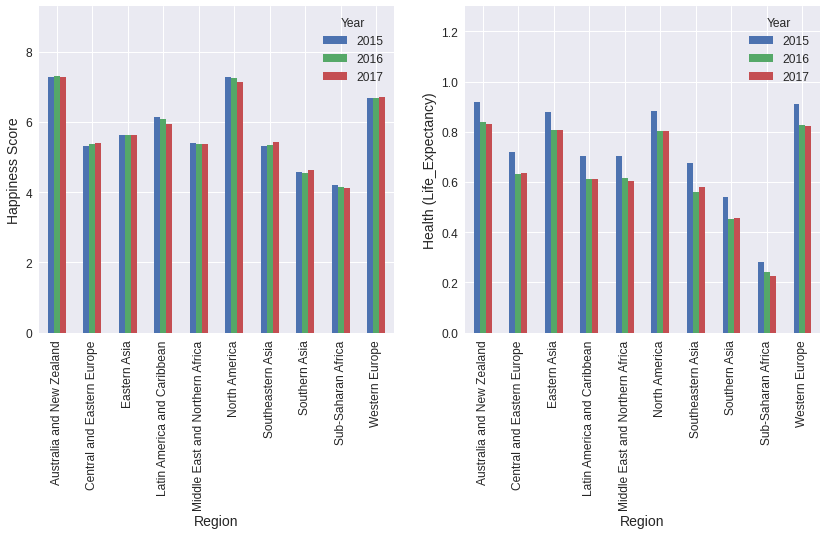

In [ ]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

table1 = pd.pivot_table(df, index='Region', columns='Year', values="Happiness_Score")
table1.plot(kind='bar', ax=ax1)
ax1.set_ylabel("Happiness Score");

table2 = pd.pivot_table(df, index='Region', columns='Year', values="Health_(Life_Expectancy)")
table2.plot(kind='bar', ax=ax2)
ax2.set_ylabel("Health (Life_Expectancy)");

## adjust the axis to accomadate the legend
ax1.set_ylim((0,9.3))
ax2.set_ylim((0,1.3))

There are some interface limitations when it comes to using the pandas interface for plotting, but it serves as an efficient first pass. You may also notice that if this notebook were to be used as a presentation there is some  exposed plot generation code that can limit communication.  There are ways to hide code in Jupyter, but in keeping with the best practices of storing code in text files for version control as well as the cataloging of plot code here is a script that makes a nicer version of the same plot with the `artist` interface. See the file for details on the additional customization.

* [make-happiness-summary-plot.py](../scripts/make-happiness-summary-plot.py)

In [ ]:
!python /content/make-happiness-summary-plot.py
Image(os.path.join(IMAGE_DIR, "happiness-summary.png"), width=800, height=600)

... data ingestion
Traceback (most recent call last):
  File "/content/make-happiness-summary-plot.py", line 127, in <module>
    df = run_data_ingestion()
  File "/content/make-happiness-summary-plot.py", line 53, in run_data_ingestion
    df = pd.read_csv(os.path.join(DATA_DIR,"world-happiness.csv"),index_col=0)
  File "/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 482, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 811, in __init__
    self._engine = self._make_engine(self.engine)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 1040, in _make_engine
   

### Pair plots and correlation

There are many useful tools and techniques for EDA that could be a part of these materials, but the focus of this course is on the workflow itself.  In addition to indispensable summary tables and simple plots there is one more that deserves special mention, because of its utility, and that is the pair plot or sometimes referred to as the pairs plot.  At a minimum these are used to visualize the relationships between all pairwise combinations of continuous variables in your data set.  Importantly, we can quantify these relationships using [correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence).  There are also ways to get additional insight into the data by overlaying discrete variables, using a coloring scheme, and including univariate distributions along the diagonal. 

* [seaborn pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
* [seaborn pairwise correlations plot](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

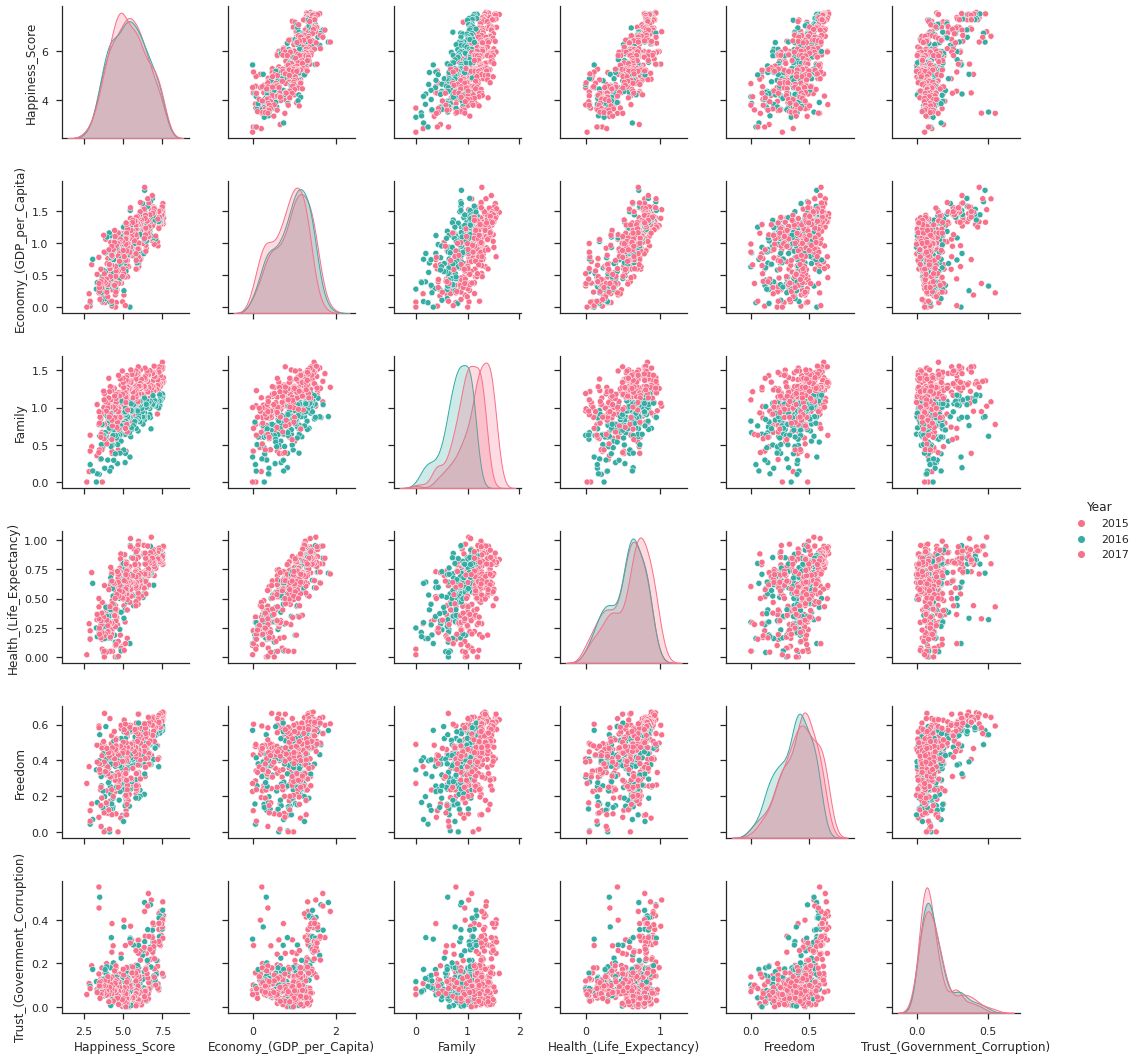

In [ ]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

## make a pair plot
columns = ['Happiness_Score','Economy_(GDP_per_Capita)', 'Family', 'Health_(Life_Expectancy)',
           'Freedom', 'Trust_(Government_Corruption)']

axes = sns.pairplot(df,vars=columns,hue="Year",palette="husl")

### QUESTION: Correlation plot

Use the [following code snippet from the seaborn examples](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) to create your own grid plot of pairwise correlations for this data set.  Do this as a separate script then run and display the image here.

**1-** Create a .py script in the `scripts` folder (You can name this script `make-happiness-corr-plot.py`). This script should have the same structure as the provided `make-happiness-summary-plot.py`. The code that you write should create a correlation matrix following the example in the link above and save this plot as a .png file in the `images` folder.<br>
**2-** Once you have run the script from this notebook, load the saved .png image in the notebook.


**Importing a .py file into a Notebook file system on Watson Studio**

Because this notebook is running on the IBM cloud platform you will have to import the .py script that you created on the file system of this notebook. To do so, you have two options.<br>
**1-** <u>Directly write the script from this notebook.</u><br>
You can write your script directly in a cell of this notebook and ask jupyter to write this code in a python separate .py file by adding the following line at the begining of the cell :
```
%%writefile ../scripts/make-happiness-corr-plot.py
```
If this line is written at the very begging of a coding cell, the reste of the code that you write on the cell will be copyed to a .py script named `make-happiness-corr-plot.py` in the `scripts` folder of your notebook's file system.

**2-** <u>Create a script locally and import it in the notebook's file system.</u><br>
If you created your .py script locally on your computer, you can import it your project just as you would import a data asset (You can review how to do so [here](https://dataplatform.cloud.ibm.com/docs/content/wsj/manage-data/add-data-project.html?audience=wdp#files)). Once your script is imported as a data asset in your project, you can import it to the notebook's file system running the following line:
```
cos2file(project, '/scripts', 'make-happiness-corr-plot.py')
```


In [ ]:
## YOUR CODE HERE
%%writefile /content/make-happiness-summary-plot.py
 

"""

ABOUT:
    example script to create a summary plot from world happiness data

DATA:
    data produced by: http://unsdsn.org/about-us/vision-and-organization
    data compilied from: https://worldhappiness.report

DIRECTORIES
    You can modify the DATA_DIR and IMAGE_DIR directly or create a directory called 'data'
    and another called 'images'.  Ensure the csv file is in the data dir

"""

######## NOTE ########
# Most of the code in this file is from make-happiness-summary-plot.py
# which is available as part of the case study.
# Code used in the solution to: ** QUESTION: Correlation plot **
# is labeled with that comment.
######################

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## plot style and fonts
plt.style.use('seaborn')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

BLUE = "#0066FF"
ORANGE = "#FF6600"
GREY = "#777777"

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title


DATA_DIR = os.path.join("","data") 
IMAGE_DIR = os.path.join("","images")


######## SOLUTION FUNC ####################
######## QUESTION: Correlation plot #######

## New import (should move this to the rest of the imports)
import seaborn as sns

def create_correlation_grid_plot(df, columns):
    """
    Create correlation grid using data from DataFrame df, specify which 
    columns to display with columns param. 

    Inspired by: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    """

    # Compute the correlation matrix
    corr = df[columns].corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    image_path = os.path.join(IMAGE_DIR,"happiness-corr-grid.png")    
    plt.savefig(image_path,bbox_inches='tight',pad_inches = 0,dpi=500)
    print("{} created.".format(image_path))

######### END: SOLUTION FUNC #############    

def run_data_ingestion():
    """
    ready the data for EDA
    """

    print("... data ingestion")
    
    ## load the data and print the shape
    df = pd.read_csv(os.path.join(DATA_DIR,"world-happiness.csv"),index_col=0)

    ## clean up the column names
    df.columns = [re.sub("\s+","_",col) for col in df.columns.tolist()]

    ## drop the rows that have NaNs
    df.dropna(inplace=True)

    ## sort the data for more intuitive visualization
    df.sort_values(['Year', "Happiness_Score"], ascending=[True, False], inplace=True)

    return(df)

if __name__ == "__main__":

    
    df = run_data_ingestion()
    numeric_columns = ['Happiness_Score','Economy_(GDP_per_Capita)', 'Family',
                      'Health_(Life_Expectancy)', 'Freedom', 
                      'Trust_(Government_Corruption)', 'Generosity',
                      'Dystopia_Residual'] 
    create_correlation_grid_plot(df, numeric_columns)


Overwriting /content/make-happiness-summary-plot.py


... data ingestion
images/happiness-corr-grid.png created.


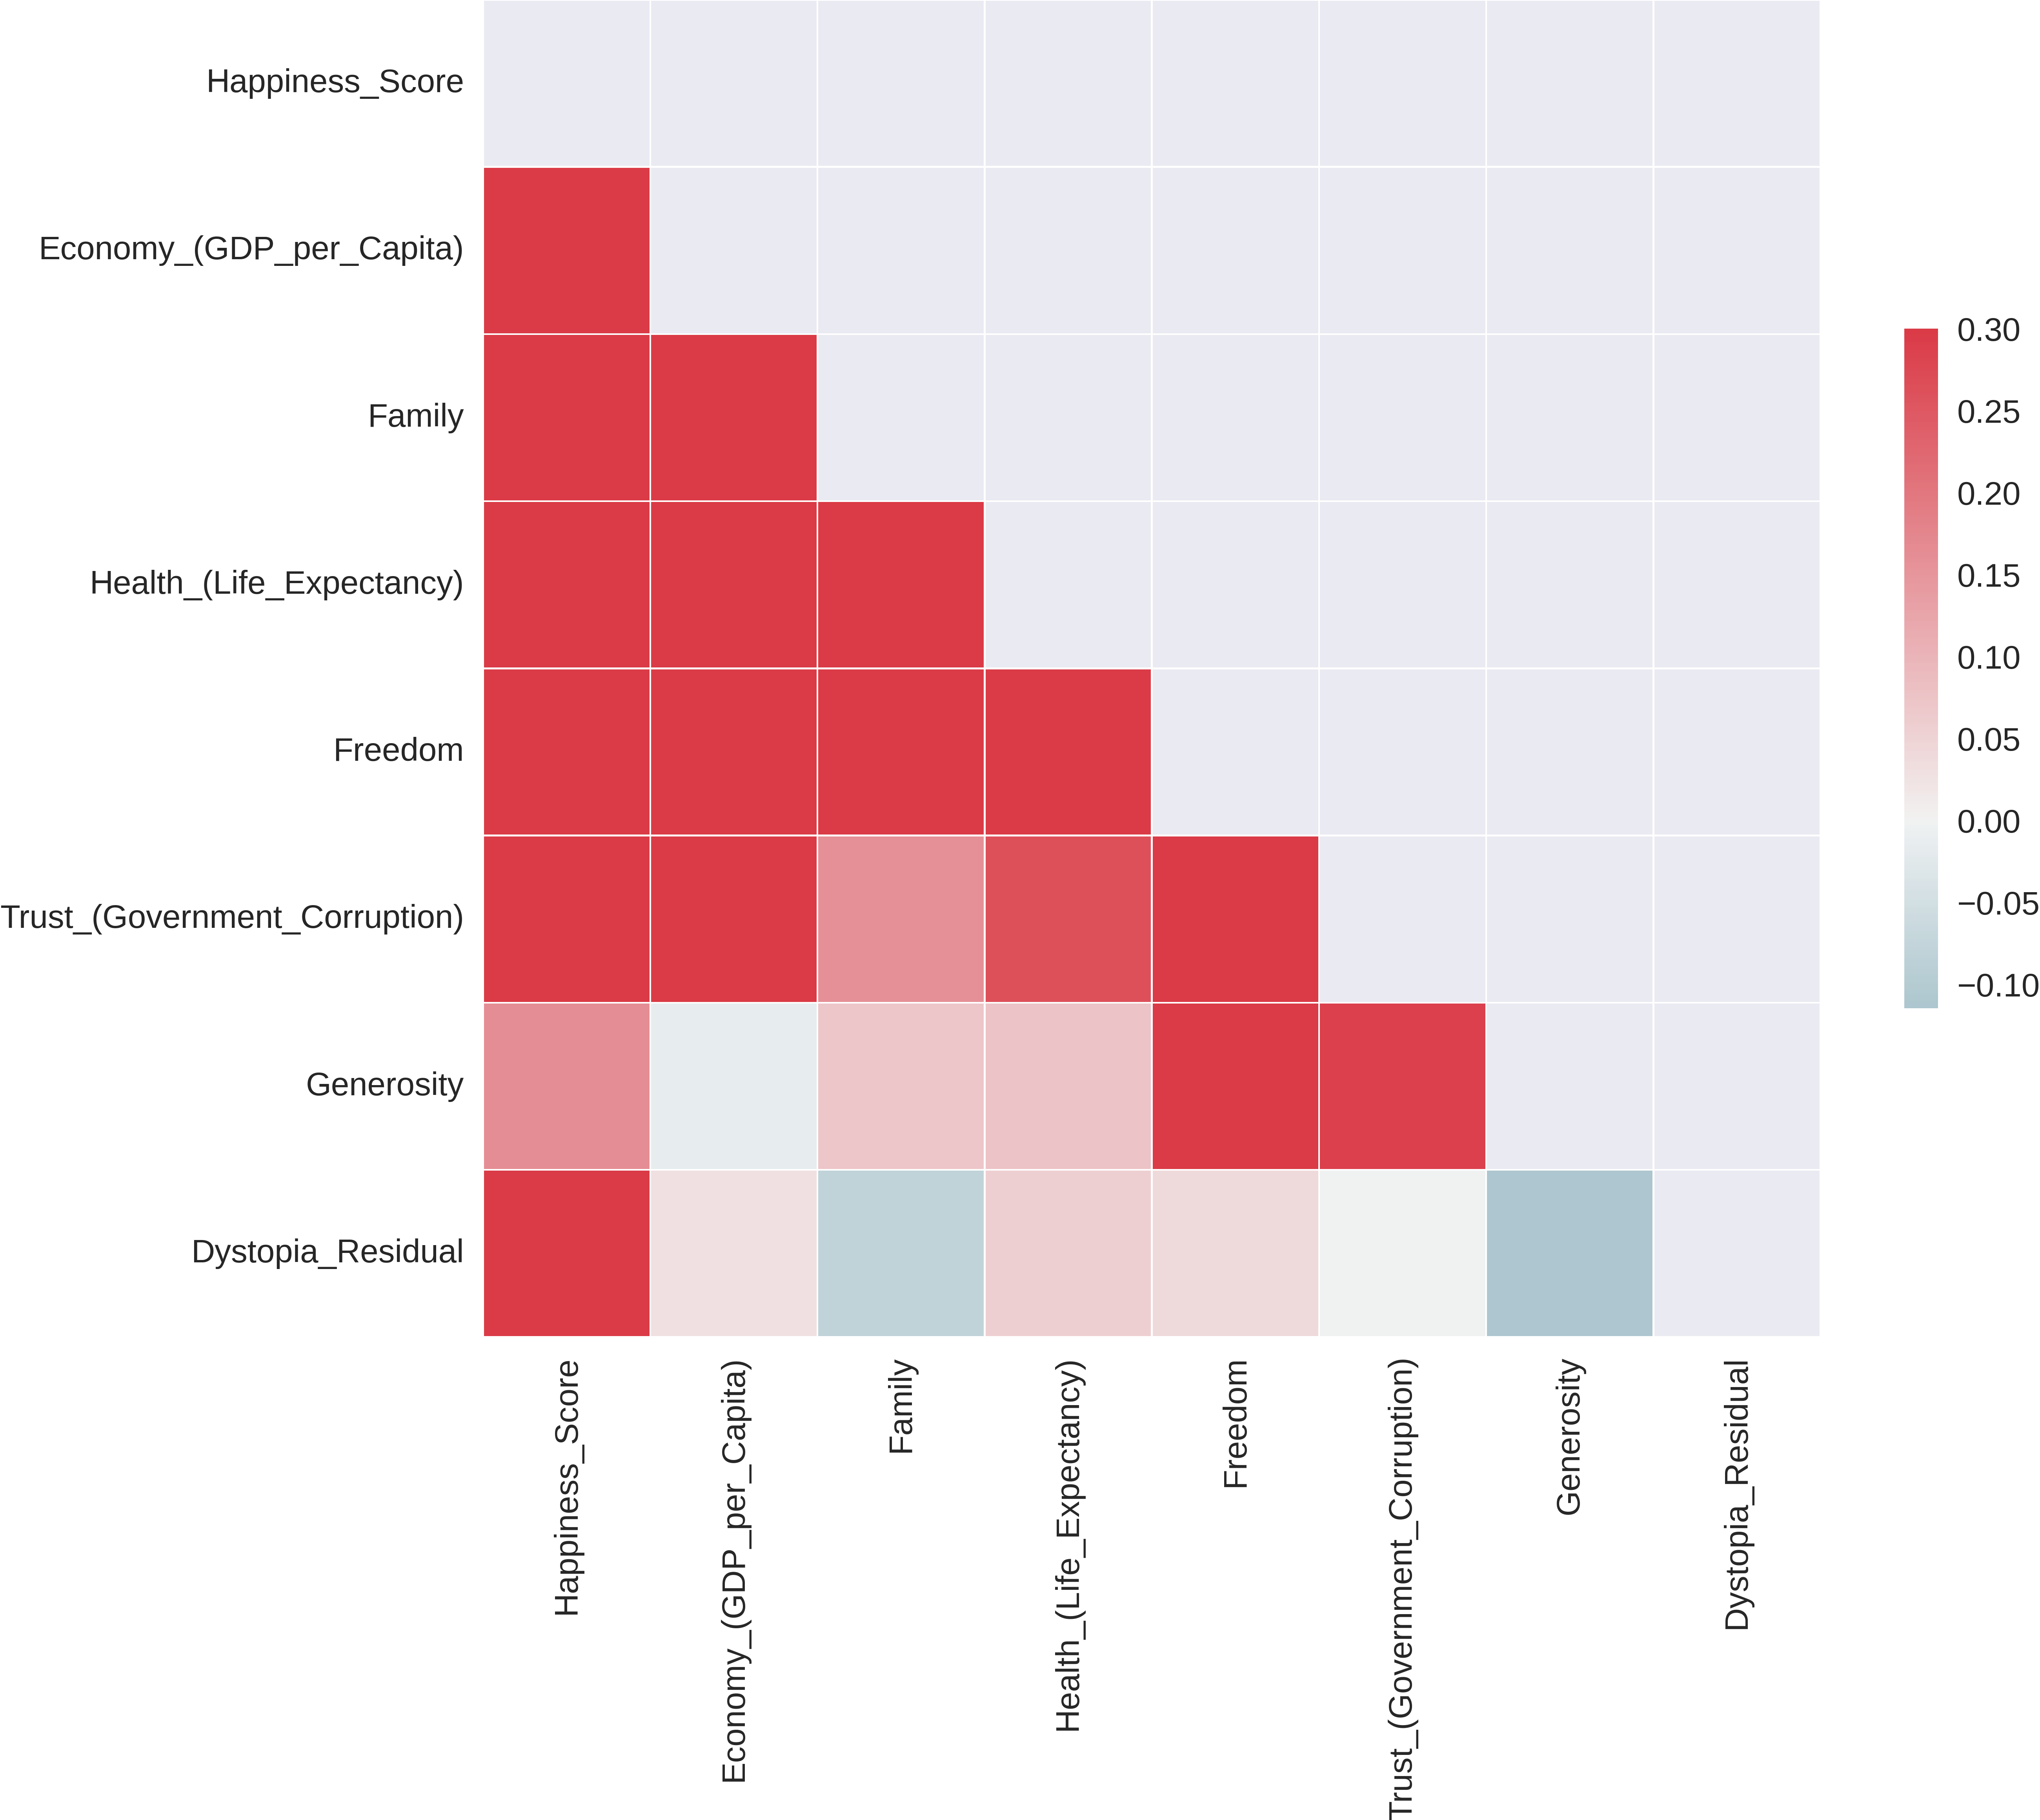

In [ ]:
!python /content/make-happiness-summary-plot.py
Image(os.path.join(IMAGE_DIR, "happiness-corr-grid.png"), width=800, height=600)

### Beyond simple plots

Simple plots are quick to produce, quick to modify and can be saved in multiple formats.  When we refer to a plot as a *simple plot* it does not necessary mean that it lacks complexity---for lack of a better term it implies that it is a plot like all of those that we have seen so far in this unit.  Dashboards, interactive plots and really any environment where a plot is no longer portable is where the term simple plots no longer apply.